### Description
- This script demonstrates how use the APRP method to compute TOA SW radiation anomalies due to individual components. We do this for the difference between piClim-aer and piClim-control RFMIP experiments for the ACCESS-CM2 model.

### Input
- Total cloud cover and SW radiative fluxes at TOA and SFC for clear- and all-sky conditions
    - standard CMIP nomenclature: clt,rsdt,rsut,rsutcs,rsds,rsus,rsdscs,rsuscs
    - flag to do forward, backward, or avg of forward / backward calcuations (the default)

### Output
- TOA SW anomalies due to changes in:
    - surface albedo (for all-, clear-, and overcast-sky conditions)
    - clouds (total change and contributions from changing cloud cover, scattering, and absorption)
    - non-cloud atmosphere (e.g., from changes in water vapor, aerosols, ozone)

- Equation numbers throughout refer to Taylor et al. (2007)   

### History
- This code is updated from demonstrate_APRP.py  (Jan 2023):
  - all calls to CDAT and Basemap replaced with xarray, xcdat, and cartopy
  - cleans up a variety of other bad coding practices
  - adds the option of doing forward, backward, or (default) the avg of both calculations    

### References
- Taylor, K. E. et al. (2007), Estimating shortwave radiative forcing and response in 
    climate models, J. Clim., 20(11), 2530-2543, doi:10.1175/JCLI4143.1.  
- Zelinka, M. D., T. Andrews, P. M. Forster, and K. E. Taylor, 2014: Quantifying Components of 
    Aerosol-Cloud-Radiation Interactions in Climate Models, J. Geophys. Res., 119, 7599-7615, doi:10.1002/2014JD021710.
- Smith, C. J., et al., 2020: Effective radiative forcing and adjustments in CMIP6 models, 
    Atmos. Chem. Phys., 20, 9591–9618, doi:10.5194/acp-20-9591-2020.
- Zelinka, M. D., C. J. Smith, Y. Qin, and K. E. Taylor, 2023: Comparison of Methods to 
    Estimate Aerosol Effective Radiative Forcings in CMIP Models, Atmos. Chem. Phys., in press. 
    
### Contact
- Mark Zelinka (zelinka1@llnl.gov)

In [1]:
#IMPORT STUFF:
#=====================
import xcdat as xc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from aprp import APRP

## Read in data from control and perturbed experiments; store in dictionary

In [2]:
variables = ['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs']
exps = ['piClim-control','piClim-aer']
prefix = '/p/css03/esgf_publish/CMIP6/RFMIP/CSIRO-ARCCSS/ACCESS-CM2/'
DATA={}
for exp in exps:
    DATA[exp]={}
    for var in variables:
        dirname = prefix+exp+'/r1i1p1f1/Amon/'+var+'/gn/v20200428/*nc'
        ds = xc.open_mfdataset(dirname)
        # Compute climatological annual cycle:
        climo = ds.temporal.climatology(var, 'month', weighted=True)
        DATA[exp][var] = climo[var]

## Run APRP function

In [3]:
output = APRP(DATA['piClim-control'],DATA['piClim-aer'])

2023-08-01 15:42:55,403 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


## Plot maps of APRP components

/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/zelinka1/miniconda3/envs/xcli

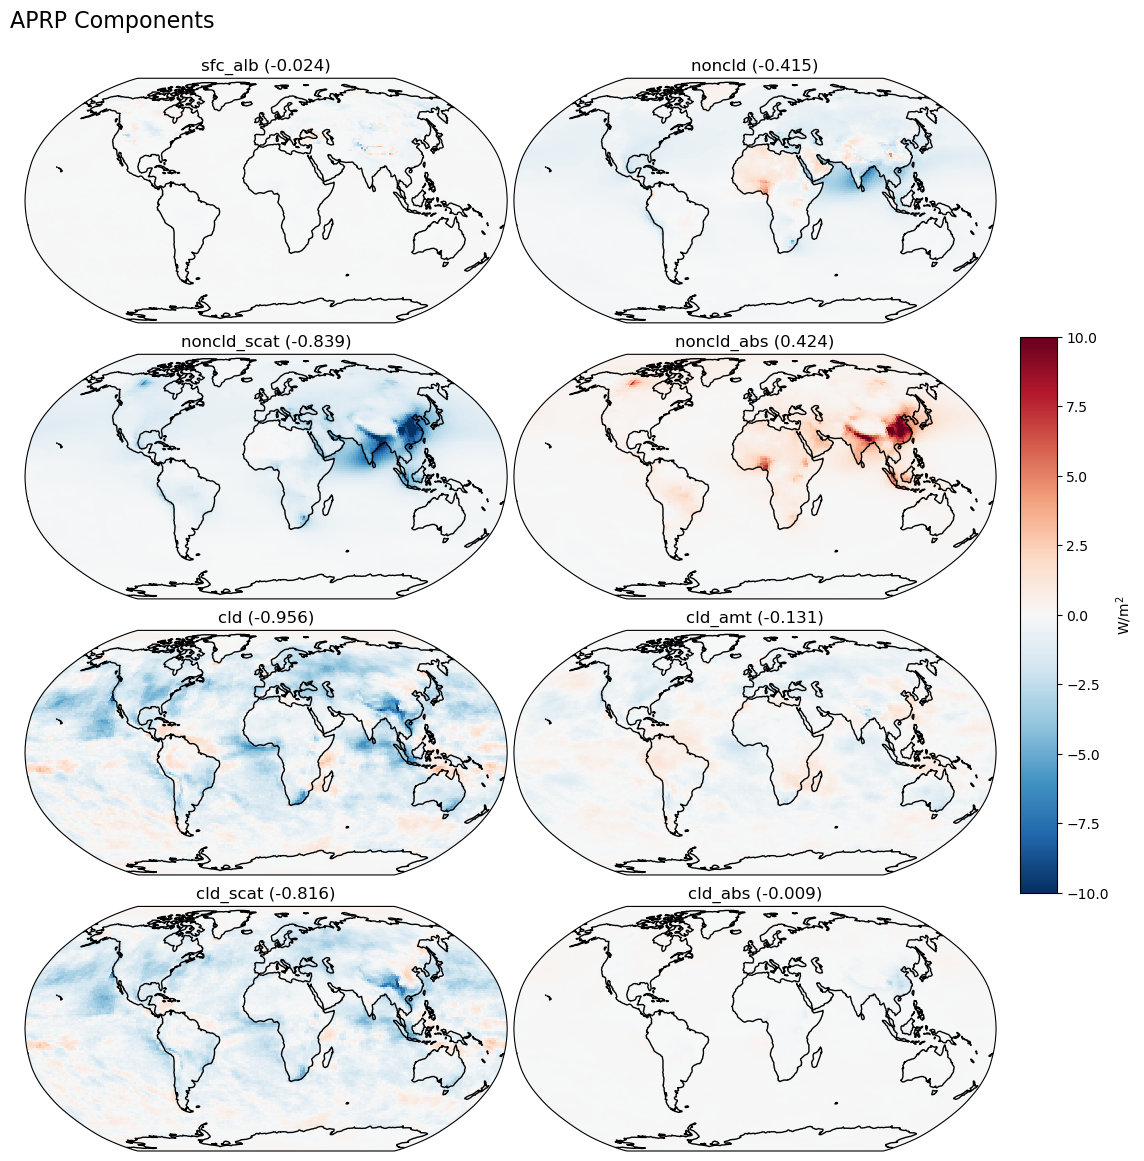

In [4]:
fields = ['sfc_alb','noncld','noncld_scat','noncld_abs','cld','cld_amt','cld_scat','cld_abs']
fig = plt.figure(figsize = (12,12))
plt.suptitle('APRP Components',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=4, ncols=2, subplot_kw={'projection': ccrs.Robinson()})
cnt=-1
for row in range(4):
    for col in range(2):
        cnt+=1
        var = fields[cnt]
        avgmap = output.temporal.average(var, weighted=True)#[var]
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -10, vmax =  10, 
                  cmap = 'RdBu_r', 
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-2)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")
        

## Verify that the sum of APRP terms reproduces the actual change in net (down minus up) SW radiation at the TOA


In [ ]:
output['drsnt'] = (DATA['piClim-aer']['rsdt']-DATA['piClim-aer']['rsut']) - \
              (DATA['piClim-control']['rsdt']-DATA['piClim-control']['rsut'])
output['sum'] = output['sfc_alb']+output['noncld']+output['cld']
output['resid'] = output['sum'] - output['drsnt']
fields = ['sum','drsnt','resid']
cnt=-1
for row in range(3):
    cnt+=1
    fig = plt.figure(figsize=(5,5))
    axes = fig.subplots(subplot_kw={'projection': ccrs.Robinson()})
    var = fields[cnt]
    avgmap = output.temporal.average(var, weighted=True)
    avgmap = avgmap.bounds.add_missing_bounds()
    avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
    if var=='resid':
        mn,mx = -.01,.01
    else:
        mn,mx = -10,10
    pl = avgmap[var].plot(ax = axes, 
              transform=ccrs.PlateCarree(),
              vmin = mn, vmax = mx, 
              cmap = 'RdBu_r', 
              add_colorbar=False)
    axes.set_title(var+" (" + f'{avg:.4f}' + ")")
    axes.coastlines()
    plt.tight_layout(w_pad=2.5,h_pad=-2)        
    fig.colorbar(pl, ax=axes, extend='both',orientation='horizontal',pad = 0.02, aspect = 50, label="W/m$^2$")
        

2023-08-01 15:44:36,795 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
/home/zelinka1/miniconda3/envs/xclim2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


## Compare to Chris Smith's implementation

In [ ]:
# Chris's code needs these to be numpy arrays:
base={}
pert={}
for var in list(DATA['piClim-aer'].keys()):
    pert[var] = DATA['piClim-aer'][var].to_numpy()
    base[var] = DATA['piClim-control'][var].to_numpy()

In [ ]:
# from smith_aprp_v2 import aprp
from smith_aprp import aprp
smith  = aprp(base, pert, longwave=False)
smith['sfc_alb'] = smith['t1'] + smith['t4']
smith['noncld_scat'] = smith['t2'] + smith['t5']
smith['noncld_abs'] = smith['t3'] + smith['t6']
smith['cld_amt'] = smith['t9']
smith['cld_scat'] = smith['t7']
smith['cld_abs'] = smith['t8']
smith['cld'] = smith['cld_amt'] + smith['cld_scat'] + smith['cld_abs']
smith['noncld'] = smith['noncld_scat'] + smith['noncld_abs']

In [ ]:
# Convert these back into an xarray dataset:
TIME = output.time
LAT = output.lat
LON = output.lon
DS = xr.Dataset(
{
    'sfc_alb':(('time','lat','lon'),smith['sfc_alb'].data),
    'cld':(('time','lat','lon'),smith['cld'].data),
    'cld_amt':(('time','lat','lon'),smith['cld_amt'].data),
    'cld_scat':(('time','lat','lon'),smith['cld_scat'].data),
    'cld_abs':(('time','lat','lon'),smith['cld_abs'].data),
    'noncld':(('time','lat','lon'),smith['noncld'].data),
    'noncld_scat':(('time','lat','lon'),smith['noncld_scat'].data),
    'noncld_abs':(('time','lat','lon'),smith['noncld_abs'].data),
},
coords={'time': TIME,'lat': LAT,'lon': LON},
) 
DS.lat.attrs["axis"] = "Y"
DS.lon.attrs["axis"] = "X"
SMITH = DS.bounds.add_missing_bounds()

In [ ]:
# Make figures showing the APRP components
fields = ['sfc_alb','noncld','noncld_scat','noncld_abs','cld','cld_amt','cld_scat','cld_abs']
fig = plt.figure(figsize = (12,12))
plt.suptitle('Chris Smith APRP Implementation',fontsize=16,x=0,ha='left')
axes = fig.subplots(nrows=4, ncols=2, subplot_kw={'projection': ccrs.Robinson()})
cnt=-1
for row in range(4):
    for col in range(2):
        cnt+=1
        var = fields[cnt]
        avgmap = SMITH.temporal.average(var, weighted=True)#[var]
        avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
        pl = avgmap[var].plot(ax = axes[row,col], 
                  transform=ccrs.PlateCarree(),
                  vmin = -10, vmax =  10, 
                  cmap = 'RdBu_r', 
                  add_colorbar=False)
        axes[row,col].set_title(var+" (" + str(np.round(avg,3)) + ")")
        axes[row,col].coastlines()
plt.tight_layout(w_pad=2.5,h_pad=-2)        
fig.colorbar(pl, ax=axes.ravel().tolist(), pad = 0.02, shrink = 0.5, aspect = 15, label="W/m$^2$")

In [ ]:
# Check if Smith's sum reproduces the true SW TOA radiation change:
SMITH['drsnt'] = (DATA['piClim-aer']['rsdt']-DATA['piClim-aer']['rsut']) - \
              (DATA['piClim-control']['rsdt']-DATA['piClim-control']['rsut'])
SMITH['sum'] = SMITH['sfc_alb']+SMITH['noncld']+SMITH['cld']
SMITH['resid'] = SMITH['sum'] - SMITH['drsnt']
fields = ['sum','drsnt','resid']
cnt=-1
for row in range(3):
    cnt+=1
    fig = plt.figure(figsize=(5,5))
    axes = fig.subplots(subplot_kw={'projection': ccrs.Robinson()})
    var = fields[cnt]
    avgmap = SMITH.temporal.average(var, weighted=True)
    avgmap = avgmap.bounds.add_missing_bounds()
    avg = avgmap.spatial.average(var, axis=["X", "Y"])[var].values
    if var=='resid':
        mn,mx = -1,1
    else:
        mn,mx = -10,10
    pl = avgmap[var].plot(ax = axes, 
              transform=ccrs.PlateCarree(),
              vmin = mn, vmax = mx, 
              cmap = 'RdBu_r', 
              add_colorbar=False)
   
    axes.set_title(var+" (" + f'{avg:.4f}' + ")")
    axes.coastlines()
    plt.tight_layout(w_pad=2.5,h_pad=-2)        
    fig.colorbar(pl, ax=axes, extend='both',orientation='horizontal',pad = 0.02, aspect = 50, label="W/m$^2$")
        